## Predict Tidal EoS

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
plt.rcParams.update({'font.size': 20})

2022-07-21 22:08:34.483464: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### 1. Load data from file and prepare for training

Load the EoS and the $M-R$ curves from processed 3P/4L data files, then normalize the data.

In [2]:
# Load the un-normalized data
R = np.loadtxt('../data/mrc_td.txt')
P = np.loadtxt('../data/eos_td.txt')

# Normalize the data
r = (R - np.min(R)) / (np.max(R) - np.min(R))
p = (P - np.min(P)) / (np.max(P) - np.min(P))

Next, perform a train-test-validation split as 80-15-5.

In [3]:
# Perform train-test-validation split: 80-15-5
x_tr, x_tv, y_tr, y_tv = train_test_split(r, p, test_size=0.2, shuffle=True, random_state=41)
x_ts, x_vl, y_ts, y_vl = train_test_split(x_tv, y_tv, test_size=0.25, shuffle=True, random_state=41)

### 2. Build DNN Model or load model from file

Construct a deep-learning neural network (DNN). The architecture and the hyperparameters of the DNN are chosen using `keras_tuner` to optimize for performance and accuracy (see `search/random_search_td.ipynb`). 

In [4]:
# Load model from file
#model = load_model("../output/model_td.h5")

# Build model from scratch
model = keras.Sequential([
    layers.Dense(200, input_shape=(100,), activation='relu'),
    layers.Dense(600, activation='relu'),
    layers.Dense(400, activation='relu'),
    layers.Dense(100, activation='linear')])

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               20200     
_________________________________________________________________
dense_1 (Dense)              (None, 600)               120600    
_________________________________________________________________
dense_2 (Dense)              (None, 400)               240400    
_________________________________________________________________
dense_3 (Dense)              (None, 100)               40100     
Total params: 421,300
Trainable params: 421,300
Non-trainable params: 0
_________________________________________________________________


2022-07-21 22:08:36.002745: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-21 22:08:36.003678: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-21 22:08:36.076392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 22:08:36.076621: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 with Max-Q Design computeCapability: 7.5
coreClock: 1.245GHz coreCount: 16 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 104.34GiB/s
2022-07-21 22:08:36.076642: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-07-21 22:08:36.078107: I tensorflow/stream_ex

### 3. Set up callbacks and training parameters

Set values of training parameters: batch size and number of epochs. Also, create optional callbacks such as early stopping and saving weights with checkpointings. 

In [5]:
batch_size = 32
num_epochs = 5000

# Set up a callback to stop early if given criteria is satisfied
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1.0e-10, patience=50)

# Setup checkpointing
ckpt_path = "../ckpts/eos_td.ckpt"
ckpt_dir = os.path.dirname(ckpt_path)

# Set up another callback that saves the model's weights
save_weights = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_path, save_weights_only=True, verbose=0)

### 4. Fit model and save training history

Train the DNN using training and testing data. Note that we still have unobserved validation data left to be used later for further testing and predicting EoS.

In [6]:
training = model.fit(x=x_tr, y=y_tr, batch_size=batch_size, validation_data=(x_ts, y_ts), \
                    epochs=num_epochs, callbacks=[stop_early, save_weights], verbose=2)

2022-07-21 22:08:36.592446: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-21 22:08:36.612918: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


Epoch 1/5000


2022-07-21 22:08:36.855668: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


138/138 - 1s - loss: 0.0094 - val_loss: 0.0058
Epoch 2/5000
138/138 - 0s - loss: 0.0057 - val_loss: 0.0058
Epoch 3/5000
138/138 - 0s - loss: 0.0048 - val_loss: 0.0043
Epoch 4/5000
138/138 - 0s - loss: 0.0043 - val_loss: 0.0066
Epoch 5/5000
138/138 - 0s - loss: 0.0039 - val_loss: 0.0040
Epoch 6/5000
138/138 - 0s - loss: 0.0037 - val_loss: 0.0037
Epoch 7/5000
138/138 - 0s - loss: 0.0039 - val_loss: 0.0041
Epoch 8/5000
138/138 - 0s - loss: 0.0035 - val_loss: 0.0044
Epoch 9/5000
138/138 - 0s - loss: 0.0037 - val_loss: 0.0036
Epoch 10/5000
138/138 - 0s - loss: 0.0041 - val_loss: 0.0034
Epoch 11/5000
138/138 - 0s - loss: 0.0033 - val_loss: 0.0040
Epoch 12/5000
138/138 - 0s - loss: 0.0034 - val_loss: 0.0030
Epoch 13/5000
138/138 - 0s - loss: 0.0032 - val_loss: 0.0048
Epoch 14/5000
138/138 - 0s - loss: 0.0032 - val_loss: 0.0027
Epoch 15/5000
138/138 - 0s - loss: 0.0031 - val_loss: 0.0028
Epoch 16/5000
138/138 - 0s - loss: 0.0030 - val_loss: 0.0033
Epoch 17/5000
138/138 - 0s - loss: 0.0034 - va

138/138 - 0s - loss: 0.0022 - val_loss: 0.0021
Epoch 136/5000
138/138 - 0s - loss: 0.0023 - val_loss: 0.0024
Epoch 137/5000
138/138 - 0s - loss: 0.0020 - val_loss: 0.0019
Epoch 138/5000
138/138 - 0s - loss: 0.0022 - val_loss: 0.0022
Epoch 139/5000
138/138 - 0s - loss: 0.0020 - val_loss: 0.0027
Epoch 140/5000
138/138 - 0s - loss: 0.0019 - val_loss: 0.0021
Epoch 141/5000
138/138 - 0s - loss: 0.0021 - val_loss: 0.0022
Epoch 142/5000
138/138 - 0s - loss: 0.0021 - val_loss: 0.0020
Epoch 143/5000
138/138 - 0s - loss: 0.0020 - val_loss: 0.0020
Epoch 144/5000
138/138 - 0s - loss: 0.0020 - val_loss: 0.0019
Epoch 145/5000
138/138 - 0s - loss: 0.0023 - val_loss: 0.0028
Epoch 146/5000
138/138 - 0s - loss: 0.0022 - val_loss: 0.0030
Epoch 147/5000
138/138 - 0s - loss: 0.0024 - val_loss: 0.0021
Epoch 148/5000
138/138 - 0s - loss: 0.0022 - val_loss: 0.0021
Epoch 149/5000
138/138 - 0s - loss: 0.0022 - val_loss: 0.0020
Epoch 150/5000
138/138 - 0s - loss: 0.0020 - val_loss: 0.0020
Epoch 151/5000
138/138 

Epoch 268/5000
138/138 - 0s - loss: 0.0020 - val_loss: 0.0018
Epoch 269/5000
138/138 - 0s - loss: 0.0018 - val_loss: 0.0024
Epoch 270/5000
138/138 - 0s - loss: 0.0018 - val_loss: 0.0021
Epoch 271/5000
138/138 - 0s - loss: 0.0018 - val_loss: 0.0017
Epoch 272/5000
138/138 - 0s - loss: 0.0018 - val_loss: 0.0020
Epoch 273/5000
138/138 - 0s - loss: 0.0019 - val_loss: 0.0021
Epoch 274/5000
138/138 - 0s - loss: 0.0020 - val_loss: 0.0025
Epoch 275/5000
138/138 - 0s - loss: 0.0019 - val_loss: 0.0023
Epoch 276/5000
138/138 - 0s - loss: 0.0019 - val_loss: 0.0020
Epoch 277/5000
138/138 - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 278/5000
138/138 - 0s - loss: 0.0017 - val_loss: 0.0019
Epoch 279/5000
138/138 - 0s - loss: 0.0017 - val_loss: 0.0021
Epoch 280/5000
138/138 - 0s - loss: 0.0020 - val_loss: 0.0018
Epoch 281/5000
138/138 - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 282/5000
138/138 - 0s - loss: 0.0018 - val_loss: 0.0020
Epoch 283/5000
138/138 - 0s - loss: 0.0017 - val_loss: 0.0019
Epoch 28

138/138 - 0s - loss: 0.0017 - val_loss: 0.0020
Epoch 401/5000
138/138 - 0s - loss: 0.0017 - val_loss: 0.0018
Epoch 402/5000
138/138 - 0s - loss: 0.0020 - val_loss: 0.0020
Epoch 403/5000
138/138 - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 404/5000
138/138 - 0s - loss: 0.0016 - val_loss: 0.0020
Epoch 405/5000
138/138 - 0s - loss: 0.0018 - val_loss: 0.0019
Epoch 406/5000
138/138 - 0s - loss: 0.0016 - val_loss: 0.0032
Epoch 407/5000
138/138 - 0s - loss: 0.0018 - val_loss: 0.0017
Epoch 408/5000
138/138 - 0s - loss: 0.0018 - val_loss: 0.0019
Epoch 409/5000
138/138 - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 410/5000
138/138 - 0s - loss: 0.0016 - val_loss: 0.0023
Epoch 411/5000
138/138 - 0s - loss: 0.0019 - val_loss: 0.0018
Epoch 412/5000
138/138 - 0s - loss: 0.0017 - val_loss: 0.0018
Epoch 413/5000
138/138 - 0s - loss: 0.0017 - val_loss: 0.0017


### 5. Check training results

Examine how well the network was trained by evaluating the model (i.e. computing the loss function) on the validation data and looking into the training history. Keep an eye on the order of magnitude of the loss function and any evidence of overfitting or underfitting. 

In [7]:
loss = model.evaluate(x_vl, y_vl, verbose=0)
print("Loss = {:.4e}".format(loss))

Loss = 1.4784e-03


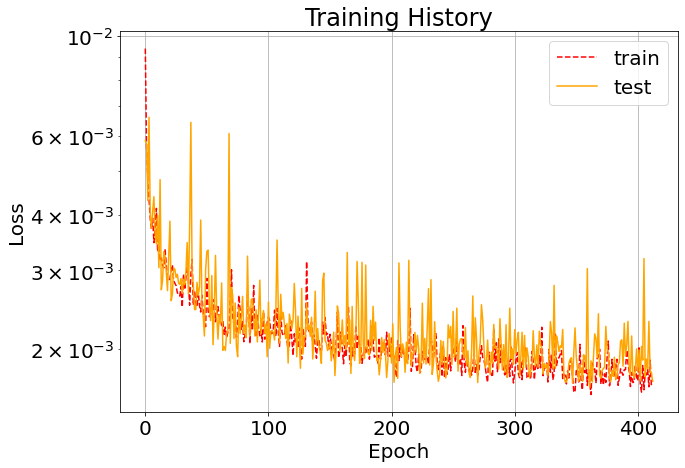

In [8]:
plt.figure(figsize=(10,7))
plt.semilogy(training.history['loss'], ls='--', color='red', label='train')
plt.semilogy(training.history['val_loss'], color='orange', label='test')
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History")
plt.legend()
plt.show()

### 6. Predict EoS and compare with data

Evaluate model with validation data and de-normalize data and prediction.

In [9]:
x = x_vl
y = y_vl
pd = np.array(model(x))

# De-normalize data and prediction
pr = np.min(P) + (np.max(P) - np.min(P)) * pd
dt = np.min(P) + (np.max(P) - np.min(P)) * y

Choose a random $M-R$ curve and predict the corresponding EoS. Plot the predicted EoS and the data for comparison.

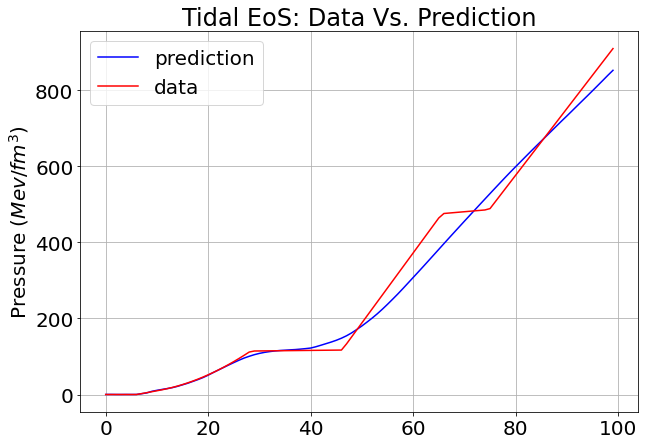

In [26]:
i = np.random.choice(x_vl.shape[0])

plt.figure(figsize=(10,7))
plt.plot(pr[i], color='blue', label='prediction')
plt.plot(dt[i], color='red', label='data')

plt.title("Tidal EoS: Data Vs. Prediction")
plt.ylabel("Pressure ($Mev/fm^3$)")
plt.legend()
plt.grid()
#plt.savefig(f"{FIGS}/real_vs_models.png")
plt.show()